In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh

from os import path

reload(read)
import wf_analysis.datasets as wfdata
reload(wfdata)

<module 'wf_analysis.datasets' from '/home/ms994/dbmi_eeg_clustering/wf_analysis/datasets.py'>

In [2]:
from predictGenderExp import get_data

In [4]:
d = get_data("dev_test", "01_tcp_ar", 1, constants.FREQ_BANDS, constants.SMALLEST_COLUMN_SUBSET, 1, False, filter=True)

Starting 1 processes
retrieving: 0


In [5]:
d

(array([[1.04599028e+08, 1.02078908e+08, 8.46691251e+07, 4.87268356e+07,
         4.87352875e+07, 3.62655781e+07, 8.43521492e+07, 8.17504826e+07,
         5.58925289e+07, 1.11612324e+08, 1.15149808e+08, 9.11204227e+07]]),
 array([[0]]))

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
%%bash
ls ..

3d_positions.csv
Neuroscan_locs_orig.mat
README.md
__pycache__
channel_names.csv
clinical_text_analysis.py
config.json
constants.py
data_labels.csv
data_reader.py
env.yaml
environmentSetup.sh
initial_clustering.py
keras_models
notebooks
out
predictAgeExp.py
predictBPMExp.py
predictBPMlr.pkl
predictBPMrf.pkl
predictGenderExp.py
predictGenderlr.pkl
predictGenderrf.pkl
run.sh
script_runner.py
seq_2_seq_exp.py
slurm-45351253.out
slurm-45351255.out
slurm-45384748.out
slurm-45384749.out
slurm-45384753.out
slurm-45390379.out
slurm-45390632.out
slurm-45390919.out
slurm-45390921.out
slurm-45390967.out
slurm-45390970.out
slurm-45392639.out
slurm-45392685.out
slurm-45403885.out
slurm-45480028.out
slurm-45492368.out
slurm-45509105.out
slurm-45512388.out
testBPMData.pkl
testGenderData.pkl
trainBPMData.pkl
trainGenderData.pkl
util_funcs.py
wf_analysis


In [6]:
trainData, trainGenders = pkl.load(open("../trainGenderData.pkl", 'rb'))
testData, testGenders = pkl.load(open("../testGenderData.pkl", 'rb'))

# Setting up RF using the best hyperparameters from CV
#### MongoDB run 2695

In [7]:
rf = RandomForestClassifier(criterion='gini', max_depth=None, max_features=0.1, 
                            min_samples_split=0.1,
                           min_weight_fraction_leaf=0.2,
                           n_estimators=50)

In [8]:
rf.fit(trainData, trainGenders)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.2, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
y_pred = rf.predict_proba(testData)

In [10]:
(y_pred[:, 1].round() == rf.predict(testData)).all()

True

In [11]:
rf.predict(testData)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
y_pred.sum()/len(y_pred)

1.0

In [13]:
roc_auc_score(testGenders, y_pred[:, 1].round())

0.5

In [14]:
fpr, tpr, z = roc_curve(testGenders, y_pred[:, 1])

Text(0, 0.5, 'TPR')

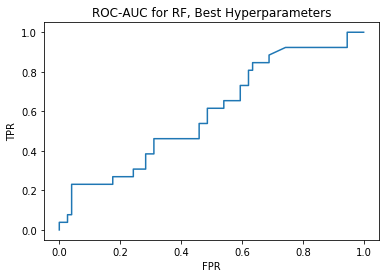

In [15]:
plt.title("ROC-AUC for RF, Best Hyperparameters")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")

In [54]:
from sklearn.metrics import confusion_matrix

In [119]:
cm = confusion_matrix(testGenders, y_pred[:,1].round())
cm = pd.DataFrame(cm, index=["female", "male"], columns=["Predict female", "Predict male"])
cm

,Predict female,Predict male
female,158,50
male,215,341


In [63]:
feat_imp = rf.feature_importances_
feat_imp.shape

(69,)

In [105]:
#From MongoDB Run 2695, just get the labels back and reassemble a 1-d list of features that corresponds to original data
channels = ["f4", "c4", "o2", "f3", "c3", "o1"]
freq_bins = [0, 3.5, 7.5, 14,20,21,22,23,24,25]
named_freq_bins = ["{}-{}".format(freq, freq_bins[freq_i + 1]) for freq_i, freq in enumerate(freq_bins[:-1])]
channel_freqs = [channel+"_freq_bin_{}-{}".format(freq, freq_bins[freq_i+1]) for freq_i, freq in enumerate(freq_bins[:-1]) for channel in channels ]
coherences = []
for k in range(len(channels) - 1):
    for j in range(k + 1, len(channels)):
        coherences.append("coherence_{}_{}".format(channels[k], channels[j]))
feats = channel_freqs + coherences

In [96]:
print(pd.Series(feat_imp, index=feats).sort_values(ascending=False))

f4_freq_bin_3.5-7.5    0.097227
coherence_c4_o2        0.089752
f4_freq_bin_7.5-14     0.071503
coherence_c4_o1        0.063287
coherence_c4_f3        0.052280
coherence_f3_c3        0.049923
coherence_f4_f3        0.038176
coherence_f4_c4        0.037007
o1_freq_bin_22-23      0.030522
coherence_o2_f3        0.028975
o1_freq_bin_3.5-7.5    0.027956
o2_freq_bin_3.5-7.5    0.026073
o2_freq_bin_7.5-14     0.021890
f3_freq_bin_0-3.5      0.020586
coherence_c3_o1        0.020531
o1_freq_bin_7.5-14     0.020137
c4_freq_bin_3.5-7.5    0.018824
o1_freq_bin_20-21      0.018385
o1_freq_bin_23-24      0.018200
c3_freq_bin_21-22      0.016730
f4_freq_bin_0-3.5      0.016494
c4_freq_bin_7.5-14     0.016140
o1_freq_bin_21-22      0.015889
coherence_f4_c3        0.015464
c4_freq_bin_22-23      0.013443
o1_freq_bin_0-3.5      0.013351
c4_freq_bin_0-3.5      0.011816
f4_freq_bin_20-21      0.011595
o2_freq_bin_24-25      0.011468
o2_freq_bin_23-24      0.011386
                         ...   
coherenc

In [118]:
cm, cm.values.reshape(-1)

(        Predict Male  Predict Female
 Male             158              50
 Female           215             341, array([158,  50, 215, 341]))

In [113]:
channel_feat_imp = pd.DataFrame(feat_imp[:len(channel_freqs)].reshape(9, 6), columns=channels, index=named_freq_bins).T
channel_feat_imp

,0-3.5,3.5-7.5,7.5-14,14-20,20-21,21-22,22-23,23-24,24-25
f4,0.016494,0.097227,0.071503,0.000000,0.011595,0.004983,0.003871,0.000000,0.000000
c4,0.011816,0.018824,0.016140,0.000861,0.000000,0.006937,0.013443,0.000000,0.000000
o2,0.006430,0.026073,0.021890,0.002704,0.009092,0.008661,0.002082,0.011386,0.011468
f3,0.020586,0.002343,0.000000,0.001217,0.000000,0.000000,0.000000,0.000000,0.004800
c3,0.004745,0.000000,0.000000,0.000000,0.000000,0.016730,0.005568,0.002499,0.000000
o1,0.013351,0.027956,0.020137,0.000713,0.018385,0.015889,0.030522,0.018200,0.006456


In [114]:
channel_feat_imp[named_freq_bins[4:]].sum(axis=1)

f4    0.020448
c4    0.020380
o2    0.042690
f3    0.004800
c3    0.024797
o1    0.089452
dtype: float64